In [271]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Calibration Step #

In [1434]:
bins = 25

path = "calibration/"
calib2 = np.loadtxt(path + "calibDig2_channel0_runOVN.txt", skiprows = 4)

time1 = calib2.T[0]
time2 = calib2.T[3]
delay = abs(time1 - time2) * 1e6 #ms
print((np.max(delay) - np.min(delay))/50)
delay2 = []
for i in range(len(delay)):
    if delay[i] < 30 and delay[i] > 2:
        delay2.append(delay[i])

fig, (ax, ax2) = plt.subplots(1, 2, figsize = (20, 8))
h = ax.hist(delay2, bins = bins, color = 'pink', edgecolor = 'black', label = 'Events', density = True)
ax.set_title("Time Delay With Random Pulses With Bias", fontsize = 17)
ax.set_xlabel(r"Time Delay ($\mu$s)", fontsize = 17)
ax.set_ylabel("Counts", fontsize = 17)
ax.grid(True, axis = 'y')

#fitting
bin_hights = h[0]
bin_edges = h[1]
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

def horiz(x, m, b):
    return m*x + b

params, cov = curve_fit(horiz, bin_centers, bin_hights)
x = np.linspace(0, 30, len(delay2))
#ax.plot(x, horiz(x, *params), color = "blue", label = "Horizontal Fit")

ax.legend(fontsize = 15)

print(f"Slope of: {params[0]:.2f} ± {(np.sqrt(cov[0][0])):.2f}")

print(max(bin_hights))

#get rid of bias
h2 = np.histogram(delay2, bins = bins)
ax2.set_title("Time Delay With Random Pulses\n With Bias Corrected", fontsize = 17)
ax2.set_xlabel(r"Time Delay ($\mu$s)", fontsize = 17)
ax2.set_ylabel("Counts", fontsize = 17)
ax2.grid(True, axis = 'y')

bin_hights2 = h2[0]
bin_edges2 = h2[1]
bin_centers2 = 0.5*(bin_edges2[1:] + bin_edges2[:-1])

ax2.hist(bin_edges2[:-1], bin_edges2, weights=bin_hights2/bin_hights, color = 'pink', edgecolor = 'black', label = 'Events')
#ax2.hist(bin_edges2[:-1], bin_edges2, weights=bin_hights2 - horiz(x, *params), color = 'pink', edgecolor = 'black', label = 'Events')

ax2.legend(fontsize = 15)



print(f"Slope of: {params[0]:.2f} ± {(np.sqrt(cov[0][0])):.2f}")
fig.suptitle("Calibration 2", fontsize = 20)

pathP = 'plots/'
#save fig
plt.savefig(pathP + "Calib2")

correction = np.max(bin_hights)

0.7863199999999999
Slope of: 0.00 ± 0.00
0.03881917184615408
Slope of: 0.00 ± 0.00


## End of Cal step #

In [1435]:

data1 = np.loadtxt('Wknd_march3.txt', skiprows = 4) #28281 events
data2 = np.loadtxt('muonRun_march8.txt', skiprows = 4) #15104 events
data3 = np.loadtxt('muonRun_march9_march13.txt', skiprows = 4) #60765 events

data = np.vstack([data1, data2, data3]) #total of 104150 events

print(np.shape(data))
numEvents_tot = 104150

#all channel 0
time1_ch0 = data.T[0]
time2_ch0 = data.T[3]
volts1_ch0 = data.T[1]
volts2_ch0 = data.T[4]
# width1_ch0 = data.T[2]
# width2_ch0 = data.T[5]

time1 = []
time2 = []
volts1 = []
volts2 = []
numEvents_cut1 = 0
for i in range(len(time1_ch0)):
    if( (volts1_ch0[i] < 0) or (volts2_ch0[i] < 0)):
        continue
    if( ((time2_ch0[i] - time1_ch0[i]) < 0) ):
        continue
    numEvents_cut1 += 1
    time1.append(time1_ch0[i])
    time2.append(time2_ch0[i])
    volts1.append(volts1_ch0[i])
    volts2.append(volts2_ch0[i])
time1 = np.array(time1)
time2 = np.array(time2)
volts1 = np.array(volts1)
volts2 = np.array(volts2)
print(numEvents_cut1)
print(f"we lost {numEvents_tot - numEvents_cut1} events")

decay = (time2 - time1) *1e6 #for ms
# distance = abs(width1 - width2)
# volt_diff = volts1 - volts2

(104150, 12)
103327
we lost 823 events


In [1436]:
first0 = 5
last0 = 0
def expo_(x, a, tau, b):
    return a * np.exp(-x/tau) + b


fig, ax = plt.subplots(figsize = (9,6))
h = ax.hist(decay, bins = bins )

bin_hights_0 = (h[0])
bin_edges_0 = (h[1])
bin_centers_0 = 0.5*(bin_edges[1:] + bin_edges[:-1])

bin_centers_ = bin_centers_0[first0:bins-last0]
bin_hights_ = bin_hights_0[first0:bins-last0]
bin_edges_ = bin_edges_0[first0:bins-last0]

params_, cov_ = curve_fit(expo_, bin_centers_, bin_hights_, p0 = [1e5, 2.2, 1])


x_ = np.linspace(10, 30, bins)
#x_ = np.linspace(1, 30, len(decay))

ax.plot(x_, expo_(x_, *params_))


remove_bkg = expo_(x_, *params_)

In [1592]:
last = 0 #remove last few bins
first = 0 #remove first few bins


def expo(x, a, tau1, b):
    return a * np.exp(-x*tau1) + b

#account for the time proper time: 

proper_time = decay*np.sqrt(1 - .9**2) # in natural units

fig, ax = plt.subplots(figsize = (9,6))
h3 = np.histogram(decay, bins = bins )

counts = h3[0]
edges = h3[1]

edges = edges[first:bins-last]
counts = counts[first:bins-last]
corrected_counts = bin_hights[first:bins-last]

#correction ############
#h_new = ax.hist(edges, edges, weights=counts/corrected_counts) #, color = 'pink', edgecolor = 'black', label = 'Events')

h_new = ax.hist(edges, edges, weights=abs(counts - bias)) #, color = 'pink', edgecolor = 'black', label = 'Events')

####################

counts_new = h_new[0]
edges_new = h_new[1]
bin_centers_new = 0.5*(edges_new[1:] + edges_new[:-1])

params, cov = curve_fit(expo, bin_centers_new, counts_new, p0 = [1e6, 1, 1e-6], maxfev=3000)

x = np.linspace(3, 15, len(decay))

ax.plot(x, expo(x, params[0], params[1], params[2]))

print(params)
print("in micro seconds")

tau = params[1] * 1e-6 # seconds
print(f"Length is then: {tau * 3e8} meters")

c_tau = tau * 3e8
g = 1/np.sqrt(1 - .9**2)

l_us = c_tau * g 
print(l_us)

# plt.plot(x, expo(x, 1e6, 1, 1e-6))
# plt.show()
numEvents = sum(counts)
print(numEvents)
print(f"events lost: {numEvents - numEvents_cut1}")

[1.49049598e+05 5.59924058e-01 1.13107744e+03]
in micro seconds
Length is then: 167.97721737027814 meters
385.36616596537243
103327
events lost: 0


## Log fit and Remove Background ##

error in tau: 0.009072752458114496
Length is then: 716269930.9037759 meters
Tau is then: 2.38756643634592 microseconds
52.45292752102661 2.38756643634592 0.0336530370221348
48.54036616692409
events lost: -103278.45963383307


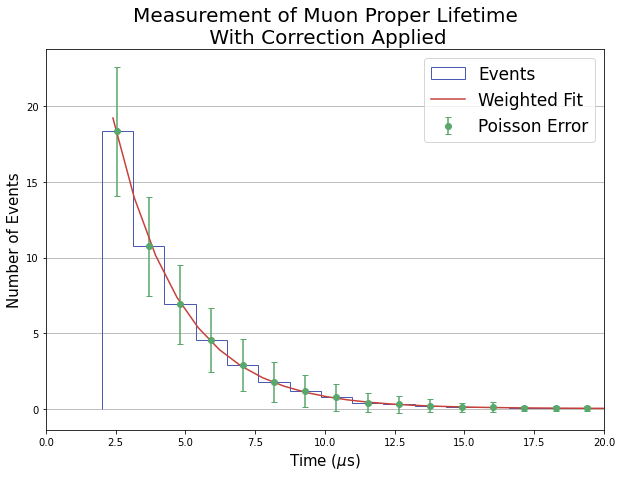

In [1593]:
def expo(x, a, tau, b):
    tau_c = 26 #ms
    return a*np.exp(-x/tau) + b*np.exp(-x/tau_c)
#declare hisgram
fig, ax = plt.subplots(figsize = (10,7))
h3 = np.histogram(decay, bins = bins )
#-----------

counts = h3[0]
edges = h3[1]

edges = edges[first:bins-last]
counts = counts[first:bins-last]
corrected_counts = bin_hights[first:bins-last]

#correction ############
#bkg = expo_(bins, *params_)#remove_bkg #(line(x_b, *params_b))
bkg = remove_bkg
weights = abs((counts - bkg )/(corrected_counts- bkg) )

h_new = ax.hist(edges, edges, weights=weights, color = '#4b5bb4', histtype = 'step', label = 'Events')
####################

counts_new = h_new[0]
edges_new = h_new[1]
bin_centers_new = 0.5*(edges_new[1:] + edges_new[:-1])
####### poisson error ######
poisson_err = []
for i in range(len(counts_new)):
    if counts[i] > 0: 
        poisson_err.append(np.sqrt(counts_new[i]))
    else: 
        poisson_err.append(1)
#-------------------------   Plotting Error --------

ax.errorbar(bin_centers_new, counts_new, yerr = poisson_err, fmt = "o", capsize = 3, color = '#58a76b', label = "Poisson Error")
params, cov = curve_fit(expo, bin_centers_new, counts_new, p0 = [1, 2.2, 1], sigma = poisson_err)
x = np.linspace(2.4, 20, len(counts_new))
ax.plot(x, expo(x, *params), color = '#c5413a', label = 'Weighted Fit')
ax.grid(True, axis = 'y')
ax.set_xlim(0, 20)
ax.set_title("Measurement of Muon Proper Lifetime\n With Correction Applied", fontsize = 20)
ax.set_xlabel(r"Time ($\mu$s)", fontsize = 15)
ax.set_ylabel("Number of Events", fontsize = 15)
ax.legend(fontsize = 17)
##### ---- SAVE IMAGE ------ ####
pathP = "plots/"
plt.savefig(pathP + "muon_lifetime2_withCorrection.png")

tau = params[1]  # seconds
tau_error = tau * 0.0038

print(f"error in tau: {tau_error}")
c_tau = tau * 3e8
print(f"Length is then: {c_tau} meters")
print(f"Tau is then: {tau } microseconds")

print(*params)

numEvents = sum(counts_new)
print(numEvents)
print(f"events lost: {numEvents - numEvents_cut1}")

In [1578]:
# p = 11
# p2 = 24

p = 0
p2 = 24

x = np.linspace(2.4, 20, len(counts_new[p:p2]))
e = np.array(poisson_err[p:p2])

print(np.shape(e), np.shape(counts_new[p:p2]), np.shape(observed[p:p2]))

expected = np.array(expo(x, *params))
observed = np.array(counts_new[p:p2])
chi2 = sum( (observed[p:p2] - expected[p:p2])**2/expected[p:p2])
chi2_w = sum( (observed[p:p2] - expected[p:p2])**2/np.mean(e)**2) 

rchi2 = chi2/(bins - 3)
rchi2_w = chi2_w/(l - 3)
print()

print(f"Chi2: {chi2:0.4f} for {bins} bins")
print(f"Chi2 (weighted): {chi2_w:0.4f} for {bins} bins")

print(f"Reduced ch0: {rchi2:0.4f}")
print(f"Reduced ch1: {rchi2_w:0.4f}")



# print(expected)
# print(observed)
# print(np.shape(expected), np.shape(observed))




(24,) (24,) (0,)

Chi2: 10.3881 for 25 bins
Chi2 (weighted): 59.5865 for 25 bins
Reduced ch0: 0.4722
Reduced ch1: 2.8375


# W/O applying the correction #
## Maybe I should try and get background from this data?#

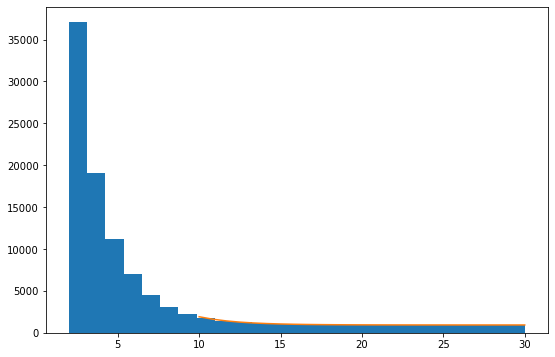

In [1431]:
first0 = 5
last0 = 0
def expo_(x, a, tau, b):
    return a * np.exp(-x/tau) + b


fig, ax = plt.subplots(figsize = (9,6))
h = ax.hist(decay, bins = bins )

bin_hights_0 = (h[0])
bin_edges_0 = (h[1])
bin_centers_0 = 0.5*(bin_edges[1:] + bin_edges[:-1])

bin_centers_ = bin_centers_0[first0:bins-last0]
bin_hights_ = bin_hights_0[first0:bins-last0]
bin_edges_ = bin_edges_0[first0:bins-last0]

params_, cov_ = curve_fit(expo_, bin_centers_, bin_hights_, p0 = [1e5, 2.2, 1])


x_ = np.linspace(10, 30, bins)
#x_ = np.linspace(1, 30, len(decay))

ax.plot(x_, expo_(x_, *params_))


remove_bkg = expo_(x_, *params_)


/Users/julietwright/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


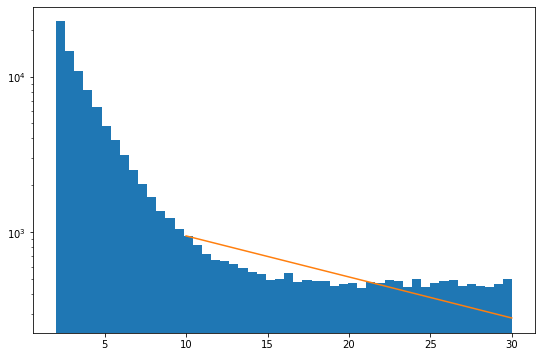

In [1357]:
first0 = 10
last0 = 0
def expo_2(x, a, m, b):
    return np.exp((m*x + b)) 


fig, ax = plt.subplots(figsize = (9,6))
h = ax.hist(decay, bins = bins )
ax.set_yscale("log", base = 10)

bin_hights_0 = (h[0])
bin_edges_0 = (h[1])
bin_centers_0 = 0.5*(bin_edges[1:] + bin_edges[:-1])

bin_centers_ = bin_centers_0[first0:bins-last0]
bin_hights_ = bin_hights_0[first0:bins-last0]
bin_edges_ = bin_edges_0[first0:bins-last0]

params_, cov_ = curve_fit(expo_2, bin_centers_, bin_hights_) #, p0 = [1e5, 2.2, 1])


x_ = np.linspace(10, 30, len(counts))
#x_ = np.linspace(1, 30, len(decay))

ax.plot(x_, expo_2(x_, *params_))


remove_bkgLog = expo_2(x_, *params_)


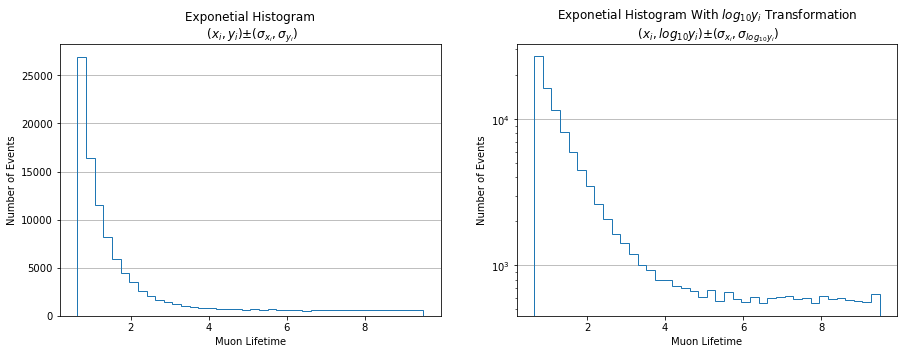

In [455]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
h = ax1.hist(proper_time, bins = bins, histtype = 'step', label = "Events") 
ax1.set_title("Exponetial Histogram\n $(x_i, y_i) ± (\sigma_{x_i}, \sigma_{y_i})$")
ax1.set_xlabel("Muon Lifetime")
ax1.set_ylabel("Number of Events")
ax1.grid(True, axis = 'y')
#transformation
hh = ax2.hist(proper_time, bins = bins, histtype = 'step', label = "Events") 
ax2.set_yscale("log", base = 10)
ax2.set_title("Exponetial Histogram With $log_{10}y_i$ Transformation\n $(x_i, log_{10}y_i) ± (\sigma_{x_i}, \sigma_{log_{10}y_i})$")
ax2.set_xlabel("Muon Lifetime")
ax2.set_ylabel("Number of Events") 
ax2.grid(True, axis = 'y')

In [1591]:
import random as rand

num = rand.randint(0,1)

if (num == 1):
    print('yes')
else:
    print('no')
    


no
